In [156]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 577.4 kB/s eta 0:03:36
   ---------------------------------------- 0.8/124.9 MB 931.2 kB/s eta 0:02:14
   ---------------------------------------- 1.0/124.9 MB 948.7 kB/s eta 0:02:11
   ---------------------------------------- 1.3/124.9 MB 958.5 kB/s eta 0:02:09
   ---------------------------------------- 1.3/124.9 MB 958.5 kB/s eta 0:02:09
    --------------------------------------- 1.6/124.9 MB 873.8 kB/s eta 0:02:22
    --------------------------------------- 1.6/124.9 MB 873.8 kB/s eta 0:02:22
    ----------

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import wget
# import zipfile


In [10]:
data = wget.download('https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv')

100% [............................................................................] 391501 / 391501

In [24]:
df = pd.read_csv(data)
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [26]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [28]:
del df['student_id']

In [30]:
df.isnull().sum()

jamb_score                        0
study_hours_per_week              0
attendance_rate                   0
teacher_quality                   0
distance_to_school                0
school_type                       0
school_location                   0
extra_tutorials                   0
access_to_learning_materials      0
parent_involvement                0
it_knowledge                      0
age                               0
gender                            0
socioeconomic_status              0
parent_education_level          891
assignments_completed             0
dtype: int64

In [32]:
df.parent_education_level = df.parent_education_level.fillna(0)

In [34]:
df.isnull().sum()

jamb_score                      0
study_hours_per_week            0
attendance_rate                 0
teacher_quality                 0
distance_to_school              0
school_type                     0
school_location                 0
extra_tutorials                 0
access_to_learning_materials    0
parent_involvement              0
it_knowledge                    0
age                             0
gender                          0
socioeconomic_status            0
parent_education_level          0
assignments_completed           0
dtype: int64

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm
import xgboost as xgb
from sklearn.metrics import roc_auc_score


In [38]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

In [40]:
len(df_train), len(df_val), len(df_test)

(3000, 1000, 1000)

In [42]:
train_set = df_train.to_dict(orient='records')
val_set = df_val.to_dict(orient='records')

In [44]:
dict_vect = DictVectorizer(sparse=False)

X_train = dict_vect.fit_transform(train_set)
X_val = dict_vect.transform(val_set)

### Question 1 

In [46]:
dec_tree = DecisionTreeRegressor(max_depth=1)
dec_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [48]:
print(export_text(dec_tree, feature_names=dict_vect.feature_names_))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



### Question 2

In [50]:
rand_forest = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rand_forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [52]:
y_pred = rand_forest.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

42.13724207871227

### Question 3 

In [54]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rand_forest = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rand_forest.fit(X_train, y_train)
    
    y_pred = rand_forest.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_sc = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

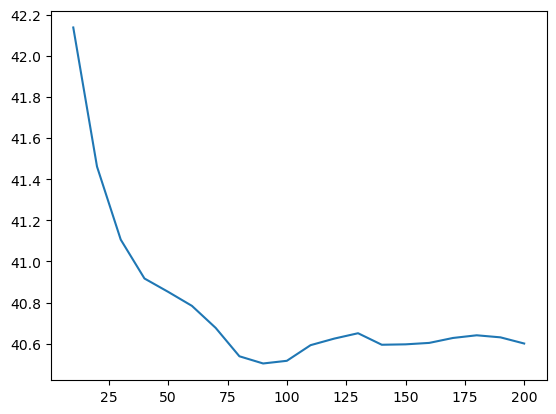

In [58]:
plt.plot(df_sc.n_estimators, df_sc.rmse.round(3))
plt.show()

### Question 4 

In [60]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rand_forest = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rand_forest.n_estimators = n
        rand_forest.fit(X_train, y_train)

        y_pred = rand_forest.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_sc = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

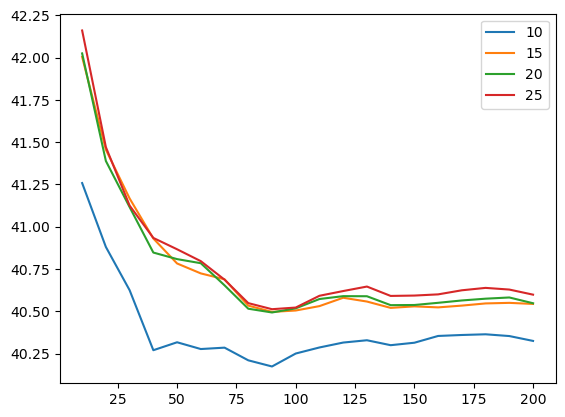

In [62]:
for d in [10, 15, 20, 25]:
    df_sub = df_sc[df_sc.max_depth == d]
    plt.plot(df_sub.n_estimators, df_sub.rmse, label=d)

plt.legend()
plt.show()

### Question 5

In [64]:
rand_forest = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rand_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [66]:
rand_forest.feature_importances_

array([0.0123254 , 0.01026189, 0.06931145, 0.03151679, 0.14972903,
       0.1364858 , 0.01345934, 0.00913136, 0.00928871, 0.01038263,
       0.01771934, 0.01240405, 0.00914148, 0.        , 0.01545036,
       0.01695692, 0.01448862, 0.02291885, 0.01335761, 0.01149201,
       0.00955909, 0.00923932, 0.0089532 , 0.00840598, 0.02571426,
       0.01070798, 0.01056268, 0.24835361, 0.08268222])

In [68]:
feature_imp = list(zip(dict_vect.feature_names_, rand_forest.feature_importances_))

df_feature = pd.DataFrame(feature_imp, columns=['feature', 'gain'])
df_feature = df_feature.sort_values(by='gain', ascending=False)
df_feature

,feature,gain
27,study_hours_per_week,0.248354
4,attendance_rate,0.149729
5,distance_to_school,0.136486
28,teacher_quality,0.082682
2,age,0.069311
3,assignments_completed,0.031517
24,socioeconomic_status=High,0.025714
17,parent_involvement=High,0.022919
10,it_knowledge=High,0.017719
15,parent_education_level=Secondary,0.016957


### Question 6

In [70]:
train_feature = list(dict_vect.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=train_feature)
val_dmatrix = xgb.DMatrix(X_val, label=y_val, feature_names=train_feature)

In [72]:
eval_data = [(dtrain, 'train'), (val_dmatrix, 'val')]
scores = {}

In [74]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=eval_data)

In [94]:
def extract_xgb_results(xgb_output):
    parsed_results = []

    for l in xgb_output.stdout.strip().split('\n'):
        iter_l, train_auc_l, val_auc_l = l.split('\t')

        iter_num = int(iter_l.strip('[]'))
        train_auc = float(train_auc_l.split(':')[1])
        val_auc = float(val_auc_l.split(':')[1])

        parsed_results.append((iter_l, train_auc, val_auc))
    
    column_names = ['num_iter', 'train_auc', 'val_auc']
    df_train_result = pd.DataFrame(parsed_results, columns=column_names)
    return df_train_result

In [100]:
scores['eta=0.3'] = extract_xgb_results(output)

In [102]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=eval_data)

In [106]:
scores['eta=0.1'] = extract_xgb_results(output)

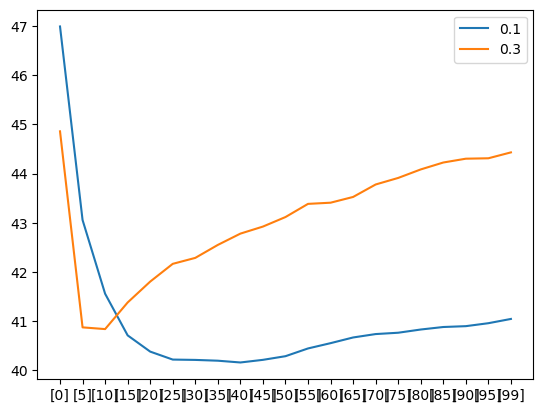

In [108]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()